# Binary classification - single_model using Naive Bayes(Tf-Idf)

# Importing and Preprocessing

## Importing libraries

In [2]:
#### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.models import ActiveLearner

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

## Importing files

In [3]:
original_data = pd.read_csv('../dataset/mohler2_cleaned.csv' ,dtype = {'question_number':str})
original_data = original_data.drop(labels='Unnamed: 0', axis=1)
original_data = original_data.rename(columns={'question_number':'question_id','question_text':'question','answer_model':'ref_answer','answer_student':'student_answer','score_avg':'grade'})

## Preprocessing

In [4]:
df = original_data.copy()

#converting to lower case
df['ref_modified'] = df['ref_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#lemmatisation
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))

# Gathering required features

In [5]:
short_df = df[['question_id','question','student_answer','student_modified','ref_modified' ,'grade']]
short_df['status'] = short_df['grade'] >= 3
short_df['status'] = short_df['status'].astype(int)
ques_id_list = list(short_df['question_id'].unique())

# FOR ONE BY ONE QUESTION
# short_df = short_df[short_df['question_id'] == ques_id_list[0]]
# ques_id_list.pop(0)
# ques_id_list
# ======================

# Bag of words

In [6]:
# Tf-idf creation
Tf = TfidfVectorizer()
tfidf_vector = Tf.fit_transform(df['student_modified'])
tfidf_vector = tfidf_vector.toarray()

X = tfidf_vector
Y = short_df['status'].values

# Seeding

In [7]:
#getting the seed index
classes = short_df['status'].unique()
seed_index = []
for i in classes:
    seed_index.append(short_df['status'][short_df['status']==i].index[0])
seed_index

[0, 5]

In [8]:
act_data = short_df.copy()
accuracy_list = []

# initialising
train_idx = seed_index
X_train = X[train_idx]
y_train = Y[train_idx]
 
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
# lr = LogisticRegression()
nb = MultinomialNB()
learner = ActiveLearner(
#     estimator = lr,
    estimator = nb,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = int(len(X)/10)
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
#     print("\nQ: ", act_data.loc[int(query_idx),'question'])
#     print("A: ",act_data.loc[int(query_idx),'student_answer'])
#     print("Actual grade: ",y_pool[query_idx].reshape(1, ))
#     print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
#     human_label = int(input("\nGive me a grade 0 or 1:"))
    
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list.append(learner.score(X,Y))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X_pool, y_pool)))
print("======================================")
print("By just labelling ",round(n_queries*100.0/len(X),2),"% of total data accuracy of ", round(learner.score(X_pool, y_pool),3), " % is achieved on the unseen data"  )

Accuracy after query no. 1: 0.129151
Accuracy after query no. 2: 0.374077
Accuracy after query no. 3: 0.131719
Accuracy after query no. 4: 0.392447
Accuracy after query no. 5: 0.871047
Accuracy after query no. 6: 0.870994
Accuracy after query no. 7: 0.855323
Accuracy after query no. 8: 0.871299
Accuracy after query no. 9: 0.871246
Accuracy after query no. 10: 0.871193
Accuracy after query no. 11: 0.871140
Accuracy after query no. 12: 0.871087
Accuracy after query no. 13: 0.871446
Accuracy after query no. 14: 0.871393
Accuracy after query no. 15: 0.871340
Accuracy after query no. 16: 0.871700
Accuracy after query no. 17: 0.871647
Accuracy after query no. 18: 0.871594
Accuracy after query no. 19: 0.871541
Accuracy after query no. 20: 0.871488
Accuracy after query no. 21: 0.871848
Accuracy after query no. 22: 0.872208
Accuracy after query no. 23: 0.872569
Accuracy after query no. 24: 0.872517
Accuracy after query no. 25: 0.872050
Accuracy after query no. 26: 0.864126
Accuracy after query 

Accuracy after query no. 215: 0.896180
Accuracy after query no. 216: 0.896133
Accuracy after query no. 217: 0.896086
Accuracy after query no. 218: 0.896490
Accuracy after query no. 219: 0.896443
Accuracy after query no. 220: 0.896396
Accuracy after query no. 221: 0.896350
Accuracy after query no. 222: 0.896303
Accuracy after query no. 223: 0.896256
Accuracy after query no. 224: 0.896661
Accuracy after query no. 225: 0.896614
Accuracy after query no. 226: 0.896567
Accuracy after query no. 227: 0.896521
Accuracy after query no. 228: 0.896474
Accuracy after query no. 229: 0.896427
Accuracy after query no. 230: 0.896380
Accuracy after query no. 231: 0.896333
Accuracy after query no. 232: 0.896286
Accuracy after query no. 233: 0.896239
Accuracy after query no. 234: 0.896646
Accuracy after query no. 235: 0.897052
Accuracy after query no. 236: 0.897005
Accuracy after query no. 237: 0.896959
Accuracy after query no. 238: 0.896912
Accuracy after query no. 239: 0.896865
Accuracy after query no. 

## Regular supervised task

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
check_X = np.copy(X)
check_Y = np.copy(Y)

X_train,X_test,Y_train,Y_test = train_test_split(check_X,check_Y,test_size = 0.2)

In [11]:
# logisticRegr = LogisticRegression()
nb.fit(X_train, Y_train)
score = nb.score(X_test, Y_test)

print(score)

0.8466257668711656


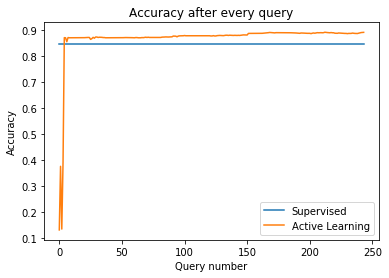

In [12]:
supervised_accuracy = [score for x in range(0,n_queries)]

plt.figure()
plt.plot(np.linspace(0,n_queries-1,n_queries),supervised_accuracy)
plt.plot(accuracy_list)
plt.title("Accuracy after every query")
plt.xlabel("Query number")
plt.ylabel("Accuracy")
plt.legend(["Supervised", "Active Learning"], loc="lower right")
plt.show()